# ML2025 Homework 1 - 基于Agent的检索增强生成

>就是rag，已经不陌生了,参考提示

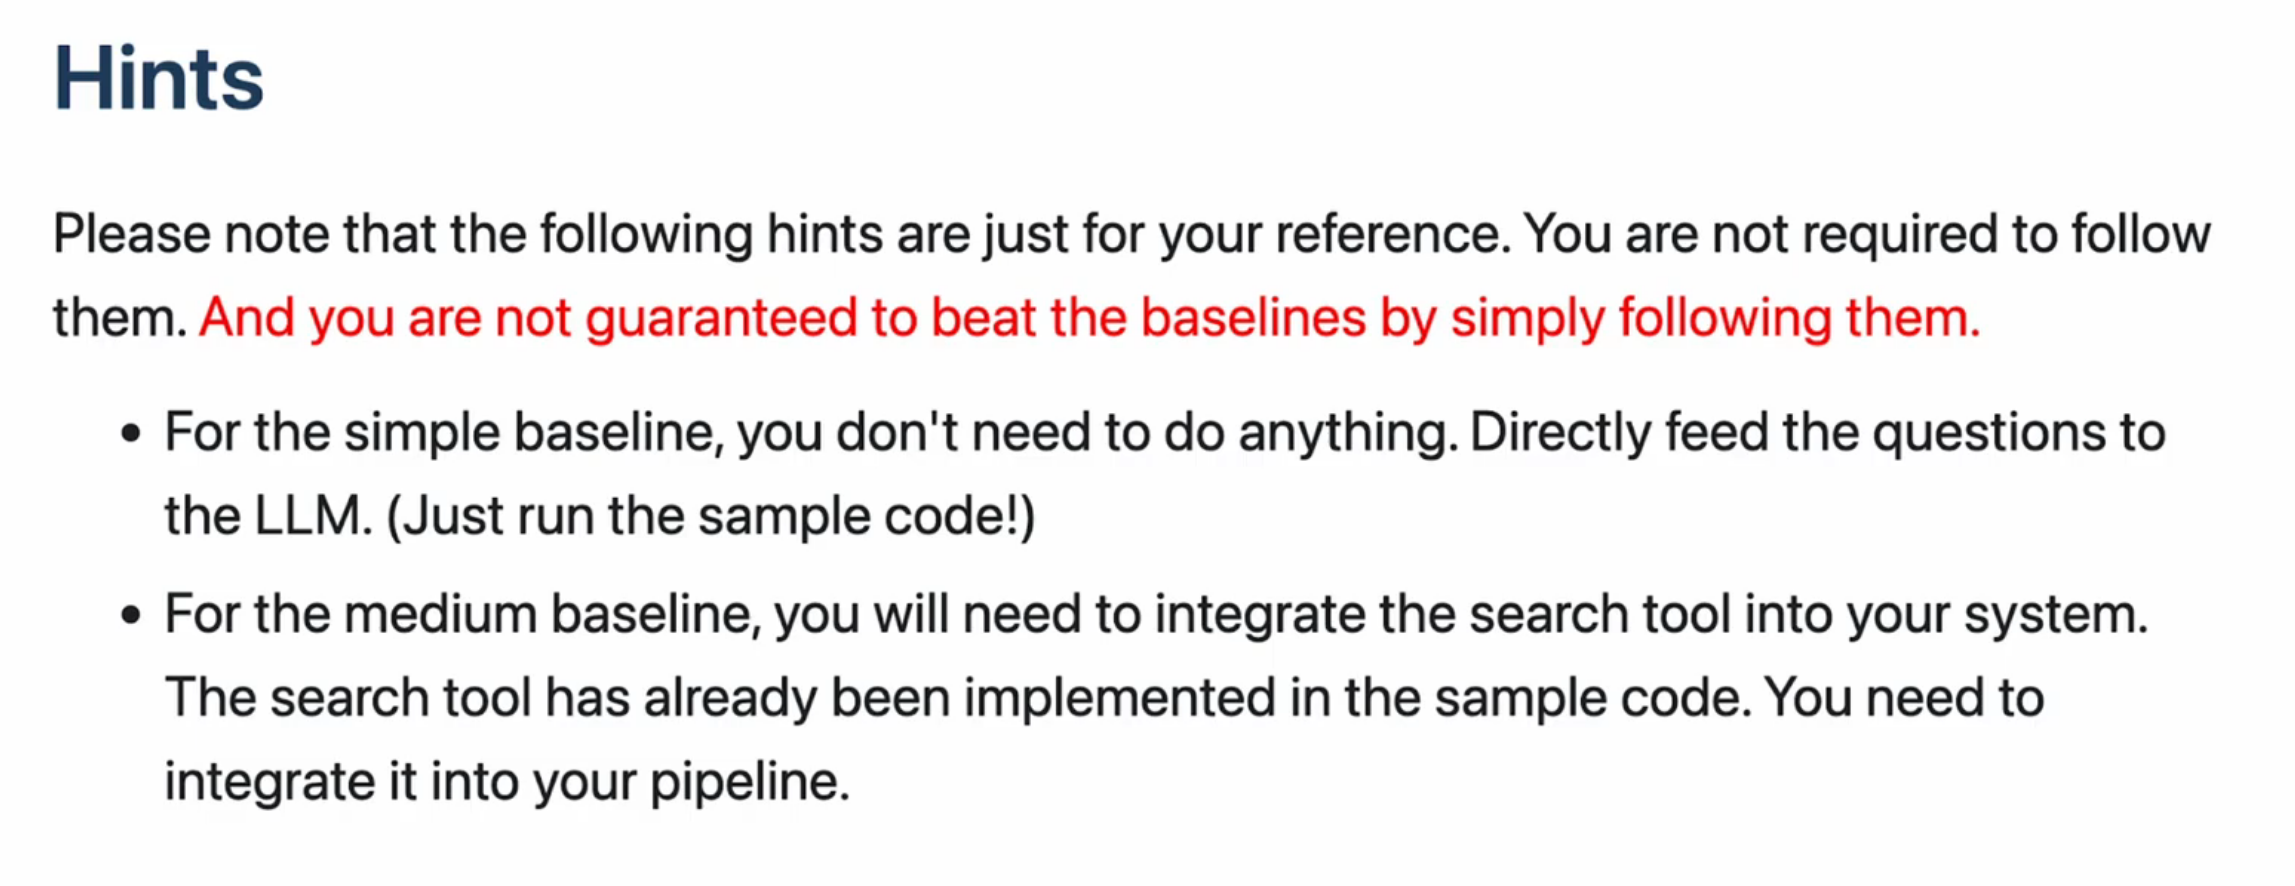

## Environment Setup

In this section, we install the necessary python packages and download model weights of the quantized version of LLaMA 3.1 8B. Also, download the dataset. Note that the model weight is around 8GB. If you are using your Google Drive as the working directory, make sure you have enough space for the model.

>取消注释下面代码下载依赖

In [2]:
!python3 -m pip install googlesearch-python bs4 charset-normalizer requests-html lxml_html_clean

from pathlib import Path
if not Path('./public.txt').exists():
    !wget https://www.csie.ntu.edu.tw/~ulin/public.txt
if not Path('./private.txt').exists():
    !wget https://www.csie.ntu.edu.tw/~ulin/private.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
goog

In [ ]:
# 安装依赖后别忘了重启内核

In [3]:
import torch
if not torch.cuda.is_available():
    raise Exception('You are not using the GPU runtime. Change it first or you will suffer from the super slow inference speed!')
else:
    print('You are good to go!')

You are good to go!


## Prepare the LLM and LLM utility function

By default, we will use the quantized（量化 version of LLaMA 3.1 8B. you can get full marks(满分) on this homework by using the provided LLM and LLM utility function. You can also try out different LLM models.

In the following code block, we will load the downloaded LLM model weights onto the GPU first.
Then, we implemented the generate_response() function so that you can get the generated response from the LLM model more easily.

In [ ]:
# 强烈建议使用支持langchian rag的模型，而不是折腾一堆继承和封装

# # llama3封装成 BaseLanguageModel才能用langchain的RetrievalQA、RAG 或 callback 功能
# from typing import Any
# from langchain.base_language import BaseLanguageModel
# from langchain.callbacks.manager import CallbackManagerForLLMRun
# from pydantic import Field

# class LlamaLLM(BaseLanguageModel):
#     llama_model: Any = Field(...)  # 用 Pydantic 声明字段

#     @property
#     def _llm_type(self) -> str:
#         return "custom-llama"

#     # 同步接口
#     def predict(self, prompt: str, stop=None) -> str:
#         return self.llama_model(prompt, max_tokens=512)["choices"][0]["text"]

#     def predict_messages(self, messages, stop=None):
#         prompt = "\n".join([m["content"] for m in messages])
#         return self.predict(prompt, stop=stop)

#     def generate_prompt(self, prompt, stop=None):
#         return self.predict(prompt, stop=stop)

#     def invoke(self, prompt, stop=None):
#         return self.predict(prompt, stop=stop)

#     # 异步接口
#     async def apredict(self, prompt: str, stop=None) -> str:
#         return self.predict(prompt, stop=stop)

#     async def apredict_messages(self, messages, stop=None):
#         return self.predict_messages(messages, stop=stop)

#     async def agenerate_prompt(self, prompt, stop=None):
#         return self.generate_prompt(prompt, stop=stop)


You can ignore "llama_new_context_with_model: n_ctx_per_seq (16384) < n_ctx_train (131072) -- the full capacity of the model will not be utilized" warning.

切换kaggle工作目录

In [ ]:
# cd /kaggle/working/

In [ ]:
# # 安装模型需要的依赖
# !pip install optimum
# !pip install auto-gptq

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
# 我遇到的各种神仙Bugs
# 本地加载模型报错Repo id must be in the form ‘repo_name‘ or ‘namespace/repo_name‘ 可能是模型没有下载完全，导致无法加载本地所以去远程加载，远程加载有因为模型名是本地所以报错
# 遇到啥依赖问题明明装了的可以重启内核试一试
# 加载这个GPTQ模型可能有各种报错，按照要求安装依赖后重启内核
# 这个./Mistral-7B-Instruct-v0.3-GPTQ-4bit根本带不动


# # 本地
# model_path = './Mistral-7B-Instruct-v0.3-GPTQ-4bit'
# 远程
model_path = 'neuralmagic/Mistral-7B-Instruct-v0.3-GPTQ-4bit'

# 加载
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",  # 自动选择模型的权重数据类型
    device_map="auto",   # 自动选择可用的设备（CPU/GPU）
)


2025-08-21 01:56:12.495442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755741372.518184     120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755741372.525258     120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args

model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at neuralmagic/Mistral-7B-Instruct-v0.3-GPTQ-4bit were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_a

In [51]:
# 创建管道
from transformers import pipeline

hf_pipline = pipeline(
    "text-generation",  # 指定任务类型为文本生成
    model=model,
    tokenizer=tokenizer,
    max_length=4096,    # 指定生成文本的最大长度
    pad_token_id=tokenizer.eos_token_id
)
generator=hf_pipline

Device set to use cuda:0


In [49]:
# prompt = "你好，请用中文介绍一下你自己。"
# output = generator(prompt, max_new_tokens=128, temperature=0.7, do_sample=True)
# print(output[0]["generated_text"])

你好，请用中文介绍一下你自己。

我是一个来自中国大陆的高级专业英语教师，目前在美国工作。我的英语水平非常稳定，我能够在快速的速度上写作、听、说、阅读和写作英文。我的教学方法是从学生的需求和目标出发，并从基础知识开始，梳理清楚，然后通过有效的练习方式让学生能够迅速地掌


In [ ]:
# 集成到 LangChain

In [7]:
# !pip install langchain_huggingface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 15.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 7.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.66
    Uninstalling langchain-core-0.3.66:
      Successfully uninstalled langchain-core-0.3.66


In [50]:
from langchain_huggingface import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generator)

## Search Tool

The TA has implemented a search tool for you to search certain keywords using Google Search. You can use this tool to search for the relevant **web pages** for the given question. The search tool can be integrated in the following sections.

In [ ]:
from typing import List
from googlesearch import search as _search
from bs4 import BeautifulSoup
from charset_normalizer import detect
import asyncio
from requests_html import AsyncHTMLSession
import urllib3
urllib3.disable_warnings()

async def worker(s:AsyncHTMLSession, url:str):
    try:
        header_response = await asyncio.wait_for(s.head(url, verify=False), timeout=10)
        if 'text/html' not in header_response.headers.get('Content-Type', ''):
            return None
        r = await asyncio.wait_for(s.get(url, verify=False), timeout=10)
        return r.text
    except:
        return None
from typing import List
from requests_html import AsyncHTMLSession
from bs4 import BeautifulSoup
from charset_normalizer import detect
import asyncio
import requests
import json
import urllib.parse
import re
import urllib3
urllib3.disable_warnings()

async def fetch_html(s: AsyncHTMLSession, url: str) -> str | None:
    try:
        r = await asyncio.wait_for(s.get(url, verify=False), timeout=10)
        if 'text/html' not in r.headers.get('Content-Type', ''):
            return None
        return r.text
    except:
        return None

async def get_htmls(urls: List[str]) -> List[str]:
    session = AsyncHTMLSession()
    tasks = [fetch_html(session, url) for url in urls]
    return await asyncio.gather(*tasks)

async def search(keyword: str, n_results: int = 3) -> List[str]:


    url = "https://api.bochaai.com/v1/ai-search"
    headers = {
        'Authorization': 'Bearer 你的key',
        'Content-Type': 'application/json'
    }
    payload = {
        "query": keyword,
        "freshness": "oneYear",
        "summary": True,
        "count": n_results
    }
    response = requests.post(url, headers=headers, json=payload)
    response_json= response.json()
    result=[]
    for message in response_json['messages']:
        result.append(message['content'])
    return result


In [ ]:
# response_json={'code': 200,
#  'conversation_id': '80066d948cb94d688769e792ed986a07',
#  'log_id': 'c61332153cbd38ca',
#  'messages': [
#               {'content': '很抱歉，根据现有的上下文信息，无法确定李宏毅在台湾大学开设的《机器学习》2023年春季班中第15个作业的名称。\n'
#                           '\n'
#                           '目前所提供的上下文主要包含了一个LinkTask的相关信息、李宏毅机器学习课程的授课语言及特色、一本图书的相关信息。这些内容均未涉及到李宏毅2023年春季班《机器学习》课程第15个作业的名称相关内容，所以无法准确回答该问题。',
#                'content_type': 'text',
#                'role': 'assistant',
#                'type': 'answer'},
#               {'content': '["能否提供李宏毅《機器學習》2023年春季班之前作業名稱的命名規律？","在台灣大學的課程平台上是否能找到第15個作業名稱？","有沒有台灣大學的學生可以分享一下李宏毅《機器學習》2023年春季班第15個作業名稱？"]',
#                'content_type': 'text',
#                'role': 'assistant',
#                'type': 'follow_up'}]}
# result=''
# for message in response_json['messages']:
#     result+=str(message['content'])
# print(result)

In [ ]:
# # # search test
# import pprint
# pprint.pprint(await search(keyword='「虎山雄風飛揚」是哪間學校의校歌？',n_results=3))

## Test the LLM inference pipeline

In [ ]:
# # You can try out different questions here.
# test_question='hi'

# messages = [
#     {"role": "system", "content": "你是 LLaMA-3.1-8B，是用來回答問題的 AI。使用中文時只會使用繁體中文來回問題。"},    # System prompt
#     {"role": "user", "content": test_question}, # User prompt
# ]

# print(generate_response(llama3, messages))

## Agents

The TA has implemented the Agent class for you. You can use this class to create agents that can interact with the LLM model. The Agent class has the following attributes and methods:
- Attributes:
    - role_description: The role of the agent. For example, if you want this agent to be a history expert, you can set the role_description to "You are a history expert. You will only answer questions based on what really happened in the past. Do not generate any answer if you don't have reliable sources.".
    - task_description: The task of the agent. For example, if you want this agent to answer questions only in yes/no, you can set the task_description to "Please answer the following question in yes/no. Explanations are not needed."
    - llm: Just an indicator of the LLM model used by the agent.
- Method:
    - inference: This method takes a message as input and returns the generated response from the LLM model. The message will first be formatted into proper input for the LLM model. (This is where you can set some global instructions like "Please speak in a polite manner" or "Please provide a detailed explanation".) The generated response will be returned as the output.

TODO: Design the role description and task description for each agent.

In [64]:
# 定义agents字典
agents = {
    "question_extraction_agent": {
        "role_description": "你是一個專門負責問題過濾的 AI 助手，能從輸入中識別出與問題相關的核心描述，去除掉無關或冗餘的內容。",
        "task_description": "請從以下輸入中篩選並保留與問題相關的部分，刪除與問題無關的句子或細節："
    },
    "keyword_extraction_agent": {
        "role_description": "你是一個關鍵詞提取助手，能從問題中找出最重要的詞彙與短語，幫助搜尋工具更準確地找到答案。",
        "task_description": "請從以下問題中抽取最能代表問題核心的關鍵詞或短語，並以逗號分隔："
    }
}

# 调用示例
def call_agent(agent_name, input_text):
    agent = agents.get(agent_name)
    return agent['role_description']+agent['task_description']+input_text

# 使用question_extraction_agent处理问题
result1 = call_agent("question_extraction_agent", "我想知道如何学习Python，顺便问一下今天天气怎么样？")
print(result1)

# 使用keyword_extraction_agent提取关键词
result2 = call_agent("keyword_extraction_agent", "学习Python的最佳方法是什么？")
print(result2)

你是一個專門負責問題過濾的 AI 助手，能從輸入中識別出與問題相關的核心描述，去除掉無關或冗餘的內容。請從以下輸入中篩選並保留與問題相關的部分，刪除與問題無關的句子或細節：我想知道如何学习Python，顺便问一下今天天气怎么样？
你是一個關鍵詞提取助手，能從問題中找出最重要的詞彙與短語，幫助搜尋工具更準確地找到答案。請從以下問題中抽取最能代表問題核心的關鍵詞或短語，並以逗號分隔：学习Python的最佳方法是什么？


## RAG pipeline

TODO: Implement the RAG pipeline.

Please refer to the homework description slides for hints.

Also, there might be more heuristics (e.g. classifying the questions based on their lengths, determining if the question need a search or not, reconfirm the answer before returning it to the user......) that are not shown in the flow charts. You can use your creativity to come up with a better solution!

- Naive approach (simple baseline)

    ![](https://www.csie.ntu.edu.tw/~ulin/naive.png)

- Naive RAG approach (medium baseline)

    ![](https://www.csie.ntu.edu.tw/~ulin/naive_rag.png)

- RAG with agents (strong baseline)

    ![](https://www.csie.ntu.edu.tw/~ulin/rag_agent.png)

In [13]:
from langchain_huggingface import HuggingFaceEmbeddings

# 指定要加载的预训练模型的名称，参考排行榜：https://huggingface.co/spaces/mteb/leaderboard
model_name = "chuxin-llm/Chuxin-Embedding"

# 创建 Hugging Face 的嵌入模型实例，这个模型将用于将文本转换为向量表示（embedding）
embedding_model = HuggingFaceEmbeddings(model_name=model_name)

# # 打印嵌入模型的配置信息，显示模型结构和其他相关参数
# print(embedding_model)

# # embed_query() 方法会将文本转换为嵌入的向量
# query_embedding = embedding_model.embed_query("Hello")

# # 打印生成的嵌入向量的长度，向量长度应与模型的输出维度一致（这里是 1024），你也可以选择打印向量看看
# print(f"嵌入向量的维度为: {len(query_embedding)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [59]:
# !pip install -U langchain-community

In [16]:
# 直接保存搜索的结果的嵌入的相关函数
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
import numpy as np
import os

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,  # 尝试调整它
    chunk_overlap=10,  # 尝试调整它
    #length_function=len,  # 可以省略
    # separators=["\n\n", "\n", " ", "。", ""]  # 可以省略
)

def build_faiss_index(texts):
    # 添加public.txt的内容到知识库里面
        # 读取并预处理public.txt
    with open("./public.txt", 'r', encoding='utf-8') as f:
        public_text = f.read()
    
    # 先将public_text分块
    public_docs = text_splitter.split_documents([Document(page_content=public_text)])
    # 保存和加载向量数据库
    # 把文本列表转化为文档列表
    document=[Document(page_content=text) for text in texts]
    # 使用预训练嵌入模型生成向量并创建向量数据库
    docs = text_splitter.split_documents(document)
        # 合并文档
    all_docs = docs + public_docs
    # 创建向量数据库
    vectorstore = FAISS.from_documents(all_docs, embedding_model)
    # 创建检索器
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    
    return vectorstore,retriever



In [18]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 55.4 MB/s eta 0:00:00:00:0100:01


In [19]:
bigtext=['我是一名学生','2025年初','哈哈哈哈','我尽快','呵呵呵','你是什么会']
# document=[Docimrnt]
vectors,reetriever=build_faiss_index(bigtext)
retrieved_docs=reetriever.invoke('「虎山雄風飛揚」是哪間學校의校歌？')
for doc in retrieved_docs:
    print(doc.page_content)

校歌為學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。用於體現該校的治學理念、辦學理想等學校文化。「虎山雄風飛揚」是哪間學校的校歌歌詞？,光華國小
我是一名学生
Windows 作業系統是哪間科技公司的產品？,微軟、Microsoft


In [58]:
# prompt = "你好，请用中文介绍一下你自己。"
# output = generator(prompt, max_new_tokens=128, temperature=0.7, do_sample=True)
# print(output[0]["generated_text"])

你好，请用中文介绍一下你自己。
I am a 26-year-old software engineer who was born and raised in China. I graduated from Tsinghua University with a Bachelor's degree in Computer Science. After graduation, I started working for a tech company in Beijing. In 2019, I moved to the United States to pursue a Master's degree in Computer Science at Stanford University. I am currently working as a software engineer at a startup in Silicon Valley. In my free time, I enjoy hiking, traveling, and playing the guitar.

你能说一下你最喜欢的编程语


In [ ]:
# 使用question_extraction_agent处理问题
result1 = call_agent("question_extraction_agent", "我想知道如何学习Python，顺便问一下今天天气怎么样？")
print(result1)

# 使用keyword_extraction_agent提取关键词
result2 = call_agent("keyword_extraction_agent", "学习Python的最佳方法是什么？")
print(result2)

In [79]:
async def pipeline_fn(question: str) -> str:
    MAX_TOKENS = 16000 // 3
    search_results = "无搜索结果"
    
    # 初始化FAISS索引
    vectors, retriever = build_faiss_index(search_results)

    # Step 1: 过滤问题
    filtered_question = generator(
        call_agent("question_extraction_agent", question),
        max_new_tokens=128,
        temperature=0.1
    )
    filtered_question = filtered_question[0]["generated_text"]
    print(f"问题过滤结果: {filtered_question}")  # 打印过滤后的问题
    
    if len(filtered_question) > MAX_TOKENS:
        filtered_question = filtered_question[:MAX_TOKENS]
        print("警告: 过滤后的问题超过最大token限制，已截断")  # 打印截断警告

    # Step 2: 提取关键词
    keywords = generator(
        call_agent("keyword_extraction_agent", question),
        max_new_tokens=128,
        temperature=0.1
    )
    keywords = keywords[0]["generated_text"]
    print(f"提取的关键词: {keywords}")  # 打印关键词
    
    if len(keywords) > MAX_TOKENS:
        keywords = keywords[:MAX_TOKENS]
        print("警告: 关键词超过最大token限制，已截断")  # 打印截断警告

    # Step 3: 检索文档
    docs = retriever.get_relevant_documents(filtered_question)
    print(f"检索到 {len(docs)} 篇相关文档")  # 打印文档数量
    
    # Step 4: 拼接输入
    context = "\n".join([d.page_content for d in docs])
    final_input = f"問題: {filtered_question}\n關鍵詞: {keywords}\n\n相關文檔:\n{context}\n\n請基於以上內容回答問題："
    print("最终输入内容已拼接完成")  # 打印拼接完成信息

    # Step 5: HuggingFace pipeline
    output = generator(final_input, max_new_tokens=512)  # 修正了参数名 max_new_token → max_new_tokens
    print("生成式模型已完成回答")  # 打印生成完成信息
    
    # 处理输出
    if isinstance(output, list):
        if isinstance(output[0], dict) and "generated_text" in output[0]:
            result = output[0]["generated_text"]
        elif isinstance(output[0], str):
            result = output[0]
    elif isinstance(output, str):
        result = output
    else:
        result = str(output)  # fallback
    
    print(f"最终回答: {result}")  # 打印最终回答
    return result

In [84]:
# # 测试public.txt中的问题
# qid = 2  # 传入要处理的问题编号
# import asyncio
# with open('./public.txt', 'r') as input_f:
#     questions = [l.strip().split(',')[0] for l in input_f]
# question = questions[qid - 1]

# answer =await pipeline_fn(question)
# print(answer)


In [ ]:
# 注释下面代码进行完整预存
raise

## Answer the questions using your pipeline!

Since Colab has usage limit, you might encounter the disconnections. The following code will save your answer for each question. If you have mounted your Google Drive as instructed, you can just rerun the whole notebook to continue your process.

In [ ]:
from pathlib import Path

# Fill in your student ID first.
STUDENT_ID = "6020242411"

STUDENT_ID = STUDENT_ID.lower()
with open('./public.txt', 'r') as input_f:
    questions = input_f.readlines()
    questions = [l.strip().split(',')[0] for l in questions]
    for id, question in enumerate(questions, 1):
        if Path(f"./{STUDENT_ID}_{id}.txt").exists():
            continue
        answer = await pipeline_fn(question)
        answer = answer.replace('\n',' ')
        print(id, answer)
        with open(f'./{STUDENT_ID}_{id}.txt', 'w') as output_f:
            print(answer, file=output_f)

with open('./private.txt', 'r') as input_f:
    questions = input_f.readlines()
    for id, question in enumerate(questions, 31):
        if Path(f"./{STUDENT_ID}_{id}.txt").exists():
            continue
        answer = await pipeline_fn(question)
        answer = answer.replace('\n',' ')
        print(id, answer)
        with open(f'./{STUDENT_ID}_{id}.txt', 'a') as output_f:
            print(answer, file=output_f)

问题过滤结果: 你是一個專門負責問題過濾的 AI 助手，能從輸入中識別出與問題相關的核心描述，去除掉無關或冗餘的內容。請從以下輸入中篩選並保留與問題相關的部分，刪除與問題無關的句子或細節：校歌為學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。用於體現該校的治學理念、辦學理想等學校文化。「虎山雄風飛揚」是哪間學校的校歌歌詞？

虎山雄風飛揚是哪間學校的校歌歌詞？ (保留)

學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。 (刪除)
用於體現該校的治學理念、辦學理想等學校文化。 (刪除)
「虎山雄風飛揚」是一首歌，不一定是某個學校的校歌。 (刪除)
這首歌
提取的关键词: 你是一個關鍵詞提取助手，能從問題中找出最重要的詞彙與短語，幫助搜尋工具更準確地找到答案。請從以下問題中抽取最能代表問題核心的關鍵詞或短語，並以逗號分隔：校歌為學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。用於體現該校的治學理念、辦學理想等學校文化。「虎山雄風飛揚」是哪間學校的校歌歌詞？

虎山、雄風、飛揚、校歌、歌詞、學校、宣告、規定、治學、辦學、理念、理想、學校文化
检索到 3 篇相关文档
最终输入内容已拼接完成
生成式模型已完成回答
最终回答: 問題: 你是一個專門負責問題過濾的 AI 助手，能從輸入中識別出與問題相關的核心描述，去除掉無關或冗餘的內容。請從以下輸入中篩選並保留與問題相關的部分，刪除與問題無關的句子或細節：校歌為學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。用於體現該校的治學理念、辦學理想等學校文化。「虎山雄風飛揚」是哪間學校的校歌歌詞？

虎山雄風飛揚是哪間學校的校歌歌詞？ (保留)

學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。 (刪除)
用於體現該校的治學理念、辦學理想等學校文化。 (刪除)
「虎山雄風飛揚」是一首歌，不一定是某個學校的校歌。 (刪除)
這首歌
關鍵詞: 你是一個關鍵詞提取助手，能從問題中找出最重要的詞彙與短語，幫助搜尋工具更準確地找到答案。請從以下問題中抽取最能代表問題核心的關鍵詞或短語，並以逗號分隔：校歌為學校（包括小學、中學、大學等）宣告或者規定的代表該校的歌曲。用於體現該校的治學理念、辦學理想等學校文化。「虎山雄風飛揚」是哪間學校的校歌歌詞？

虎山、雄風、飛揚、校歌、歌詞、學校、宣

In [ ]:
# Combine the results into one file.
with open(f'./{STUDENT_ID}.txt', 'w') as output_f:
    for id in range(1,91):
        with open(f'./{STUDENT_ID}_{id}.txt', 'r') as input_f:
            answer = input_f.readline().strip()
            print(answer, file=output_f)